In [26]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import collections
import csv
import numpy
import pandas as pd
import efficientnet.keras as efn
from collections import Counter
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [27]:
train_path= 'train'
valid_path = 'valid'
test_path = 'test'
train_batches = ImageDataGenerator(rescale = 1.0/255.,zoom_range=0.2).flow_from_directory(directory=train_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)
test_batches = ImageDataGenerator(rescale = 1.0/255.).flow_from_directory(directory=test_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10,shuffle=False)
valid_batches = ImageDataGenerator(rescale = 1.0/255.).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)


Found 4123 images belonging to 4 classes.
Found 882 images belonging to 4 classes.
Found 918 images belonging to 4 classes.


In [28]:
imgs, labels = next(train_batches)

In [29]:
#plot images 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr , axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

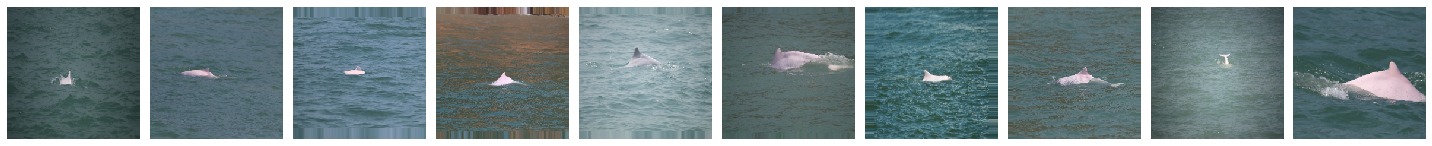

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [30]:
plotImages(imgs)
print(labels)


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# efficientnet
##### https://github.com/Tony607/efficientnet_keras_transfer_learning/blob/master/Keras_efficientnet_transfer_learning.ipynb

In [36]:
base_model = efn.EfficientNetB7(weights = 'imagenet', include_top=False , input_shape=(224,224,3))
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [37]:
model=Sequential()
model.add(base_model)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(Dense(300, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()
        

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2560)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               768300    
_________________________________________________________________
batch_normalization_6 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)              

In [38]:
base_model.trainable=False

In [39]:
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers after freezing the conv base: 10


In [40]:
counter = Counter(train_batches.classes)
max_val = float(max(counter.values()))
class_weights={class_id : max_val/num_images for class_id, num_images in counter.items()}
print(class_weights)

{0: 1.0, 1: 5.24235294117647, 2: 2.8060453400503778, 3: 3.2958579881656807}


In [41]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_1=model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=20,verbose=2)

Epoch 1/20
413/413 - 1156s - loss: 4.4296 - accuracy: 0.3226 - val_loss: 1.1636 - val_accuracy: 0.4641
Epoch 2/20
413/413 - 1138s - loss: 3.6206 - accuracy: 0.3878 - val_loss: 1.0812 - val_accuracy: 0.5566
Epoch 3/20
413/413 - 1147s - loss: 3.1953 - accuracy: 0.4409 - val_loss: 1.0985 - val_accuracy: 0.5556
Epoch 4/20
413/413 - 1150s - loss: 2.9916 - accuracy: 0.4589 - val_loss: 1.3071 - val_accuracy: 0.4978
Epoch 5/20
413/413 - 1150s - loss: 2.8245 - accuracy: 0.4780 - val_loss: 1.2802 - val_accuracy: 0.5076
Epoch 6/20
413/413 - 1146s - loss: 2.7735 - accuracy: 0.4904 - val_loss: 1.2829 - val_accuracy: 0.5087
Epoch 7/20
413/413 - 1140s - loss: 2.7576 - accuracy: 0.4992 - val_loss: 1.0938 - val_accuracy: 0.6002
Epoch 8/20
413/413 - 1139s - loss: 2.7001 - accuracy: 0.4941 - val_loss: 1.2415 - val_accuracy: 0.5468
Epoch 9/20
413/413 - 1139s - loss: 2.5964 - accuracy: 0.5176 - val_loss: 1.2336 - val_accuracy: 0.5283
Epoch 10/20
413/413 - 1139s - loss: 2.3972 - accuracy: 0.5329 - val_loss:

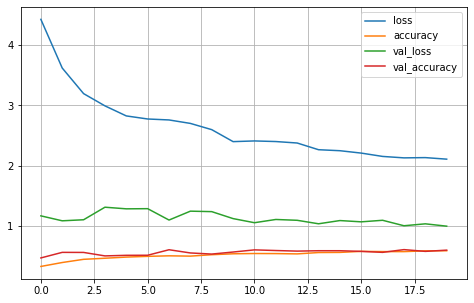

In [42]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[373  11  14  59]
 [ 34  64  40   0]
 [ 40  59 129  11]
 [  0   0   0  48]]


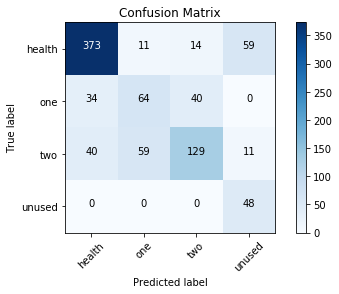

In [43]:
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [44]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       457
           1       0.48      0.46      0.47       138
           2       0.70      0.54      0.61       239
           3       0.41      1.00      0.58        48

    accuracy                           0.70       882
   macro avg       0.61      0.70      0.62       882
weighted avg       0.72      0.70      0.70       882



In [45]:
model.save('efficientnetb7_v2_one_four_trips.h5')

# finetuning

In [46]:
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_2=model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=30,verbose=2)

Epoch 1/30
413/413 - 1950s - loss: 2.5184 - accuracy: 0.4962 - val_loss: 1.5987 - val_accuracy: 0.4020
Epoch 2/30
413/413 - 1928s - loss: 1.8275 - accuracy: 0.6258 - val_loss: 2.1612 - val_accuracy: 0.3943
Epoch 3/30
413/413 - 1929s - loss: 1.5691 - accuracy: 0.6837 - val_loss: 1.7780 - val_accuracy: 0.4248
Epoch 4/30
413/413 - 1928s - loss: 1.4148 - accuracy: 0.7213 - val_loss: 2.0586 - val_accuracy: 0.4031
Epoch 5/30
413/413 - 1927s - loss: 1.3153 - accuracy: 0.7334 - val_loss: 2.3763 - val_accuracy: 0.3922
Epoch 6/30
413/413 - 1929s - loss: 1.2049 - accuracy: 0.7589 - val_loss: 2.3827 - val_accuracy: 0.4259
Epoch 7/30
413/413 - 1928s - loss: 1.1066 - accuracy: 0.7887 - val_loss: 1.8953 - val_accuracy: 0.4869
Epoch 8/30
413/413 - 1927s - loss: 0.9945 - accuracy: 0.8001 - val_loss: 1.6751 - val_accuracy: 0.5207
Epoch 9/30
413/413 - 1929s - loss: 0.9319 - accuracy: 0.8140 - val_loss: 2.2442 - val_accuracy: 0.4728
Epoch 10/30
413/413 - 1927s - loss: 0.8770 - accuracy: 0.8149 - val_loss:

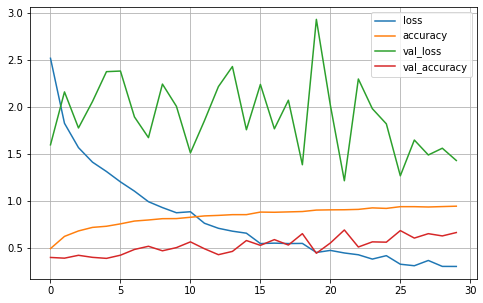

In [48]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[388  28  36   5]
 [  7  93  38   0]
 [ 24  48 167   0]
 [  0   0   0  48]]


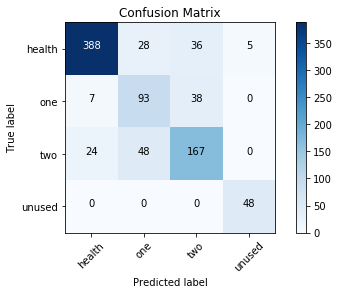

In [49]:
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [50]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       457
           1       0.55      0.67      0.61       138
           2       0.69      0.70      0.70       239
           3       0.91      1.00      0.95        48

    accuracy                           0.79       882
   macro avg       0.77      0.81      0.78       882
weighted avg       0.80      0.79      0.79       882



In [51]:
model.save('efficientnetb7_v2_finetune_one_four_trips.h5')

In [52]:
list_predictions=list(np.argmax(predictions, axis=-1))
list_filename = test_batches.filenames
final_predictions=[]
for item in zip(list_filename,list_predictions):
    final_predictions.append(item)

#predictions and labels 
arr = numpy.array(final_predictions)

# convert array into dataframe 
DF = pd.DataFrame(arr) 
  
# save the dataframe as a csv file 
DF.to_csv("efficientnetb7_finetune.csv")

In [25]:
list_unique=list(set(list_predictions))
print(list_unique)

[0, 1, 2, 3]


In [23]:
list_predictions=list(np.argmax(predictions, axis=-1))
list_filename = test_batches.filenames
final_predictions=[]
for item in zip(list_filename,list_predictions):
    final_predictions.append(item)

#predictions and labels 
arr = numpy.array(final_predictions)

# convert array into dataframe 
DF = pd.DataFrame(arr) 
  
# save the dataframe as a csv file 
DF.to_csv("data1.csv")